# Stochastic simulation assignment 2
## Peter Voerman and Nick van Santen
### 11749547 and 11857846

In [1]:
import bisect
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import scipy.stats

In [2]:
class Server():

    def __init__(self, env, n_machines):
        self.env = env
        self.machine = simpy.PriorityResource(env, n_machines)

    def run_task(self, waiting_time):
        yield self.env.timeout(waiting_time)

    @property
    def queue_length(self):
        return len(self.machine.queue)


def process_task(env, server, data, waiting_times, duration, shortest_job_first, time_choice):
    if time_choice == 'm':
        waiting_time = generate_random_markov(duration)
        if shortest_job_first:
            bisect.insort(waiting_times, waiting_time)
            index = (waiting_times.index(waiting_time))

            for request in server.machine.queue:
                if request.priority >= index:
                    request.priority += 1
        else:
            index = 1
            
    elif time_choice == 'd':
        waiting_time = duration
        index = 1
    

    #print(f"{task} added to server at {env.now}. Queue length: {server.queue_length}")
    time_at_queue = env.now
    with server.machine.request(priority=index) as request:
        yield request

        #print(f"{task} is being processed at {env.now}")
        time_start_process = env.now
        yield env.process(server.run_task(waiting_time))
        #print(f"{task} is completed at {env.now}")
        time_end_process = env.now
        

    data["wait_times"].append(time_start_process - time_at_queue)
    data["process_times"].append(time_end_process - time_start_process)

def setup(env, init, data):
    INIT_TASKS = init[0]
    N_MACHINES = init[1]

    MARKOV_TASK_DURATION = init[2]
    MARKOV_TASK_ARRIVAL = init[3]
    shortest_job_first = init[4]
    time_choice = init[5]

    server = Server(env, N_MACHINES)
    waiting_times = []

    for i in range(INIT_TASKS):
        env.process(process_task(env, server, data, waiting_times, MARKOV_TASK_DURATION, shortest_job_first, time_choice))

    while True:
        yield env.timeout(generate_random_markov(MARKOV_TASK_ARRIVAL))
        i += 1
        # if server.queue_length > 0:
        #     print(server.machine.queue)
        env.process(process_task(env, server, data, waiting_times, MARKOV_TASK_DURATION, shortest_job_first, time_choice))


def generate_random_markov(lamda):
    """
    Markov CDF: y = 1 - e^(-lamda t)
    The y value has a range of 0 to 1, which we can sample.
    Thus we can obtain a random t value by sampling y

    t = - ln(1 - y) / lamda
    """

    r = random.random()
    return -math.log(1 - r) / lamda

def generate_long_tail():
    """
    Generate a random number from a distribution where 75% of the jobs have an exponential distribution
    with an average service time of 1.0 and the remaining 25% an exponential distribution
    with an average service time of 5.0.

    The average of the exponential distribution is 1 / lamda. Thus lamda = 1 / expectation.
    """

    r = random.random()
    
    if r < 0.75:
        lamda = 1 / 1
    else:
        lamda = 1 / 5
    
    return generate_random_markov(lamda)

In [3]:
def run(init):
    data = {
    "wait_times": [],
    "process_times": [],
    }
    env = simpy.Environment()
    env.process(setup(env, init, data))
    env.run(until=MAX_SIM_TIME)
    
    avg_wait_time = np.mean(data["wait_times"])
    avg_process_time = np.mean(data["process_times"])   
    
    # print(f"Avg wait time: {avg_wait_time}")
    # print(f"Avg process time: {avg_process_time}")
    
    return avg_wait_time, avg_process_time

In [ ]:
INIT_TASKS = 4
N_MACHINES = 1
MAX_SIM_TIME = 10000

MARKOV_TASK_DURATION = 1
MARKOV_TASK_ARRIVAL = 0.9
shortest_job_first = True
time_choice = 'm'

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("Shortest job first:")
run(init)

shortest_job_first = False

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("First in first out:")
run(init)

In [ ]:
INIT_TASKS = 4
N_MACHINES = 2
MAX_SIM_TIME = 10000

MARKOV_TASK_DURATION = 1
MARKOV_TASK_ARRIVAL = 1.8
shortest_job_first = True

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("Shortest job first:")
run(init)

shortest_job_first = False

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("First in first out:")
run(init)

In [ ]:
INIT_TASKS = 4
N_MACHINES = 1
MAX_SIM_TIME = 100000

MARKOV_TASK_DURATION = 1
MARKOV_TASK_ARRIVAL = 0.9
shortest_job_first = True
time_choice = 'd'

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("Shortest job first:")
run(init)

shortest_job_first = False

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("First in first out:")
run(init)

## Statistical significance

In [4]:
def calc_pvalue(data1, data2):
    """Calculates the pvalue for two data sets. """

    return scipy.stats.ttest_ind(data1, data2).pvalue

def plot_rho_significance(xs, ys, ci):

    fig, ax = plt.subplots()
    ax.plot(xs,ys)
    ax.fill_between(xs, ys - ci, ys + ci, color='b', alpha=.1)
    ax.set_xlabel("rho")
    ax.set_ylabel("# experiments")

    plt.show()

def calc_plot_data(rhos, lamda, nruns):

    data = []
    for _ in range(nruns):

        results = calc_rho_significance(rhos, lamda)
        data.append(results)

    data = np.array(data)
    y_averages = np.mean(data, axis=0)
    y_std = np.std(data, axis=0)

    return y_averages, y_std

def calc_rho_significance(rhos, lamda):
    """
    Will look into how many experiments are needed to have significant difference 
    between multiple configurations. And how this depends on rho
    """

    results = []
    for rho in rhos:
        results.append(n_experiments(rho, lamda))

    return results

    print(rhos)
    print(results)
    
    plt.xlabel("rho")
    plt.ylabel("# experiments")
    plt.plot(rhos, results)
    plt.show()

def n_experiments(rho, lamda):

    p_significance = 0.05
    max_counter = 10000

    datas = [[], [], []]
    counter = 0
    
    while True:

        datas[0] += generate_data(rho, lamda, 1, 1)
        datas[1] += generate_data(rho, lamda, 2, 1)
        datas[2] += generate_data(rho, lamda, 4, 1)

        counter += 1

        # If counter is 1 then there is only one data point for each configuration.
        # There is no way to perform a ttest with one data point
        if counter == 1:
            continue

        # Calc p value for each combination of the data sets
        pvalue01 = calc_pvalue(datas[0], datas[1])
        pvalue02 = calc_pvalue(datas[0], datas[2])
        pvalue12 = calc_pvalue(datas[1], datas[2])

        print(f"\r{rho:.2f}, {counter}, {pvalue01}, {pvalue02}, {pvalue12}", end="")
        if pvalue01 < p_significance and pvalue02 < p_significance and pvalue12 < p_significance:
            print("")
            return counter

        if counter >= max_counter:
            print("WARNING: terminating early")
            return max_counter

def generate_data(rho, lamda, n_machines, nruns):

    # Calculate the server capacity needed to achieve an average server load of rho
    mu = lamda / (n_machines * rho)

    data = []
    for i in range(nruns):
        
        # Each machine is initialized with 1 task
        # The expectation value for the arrival rate is lamda 
        # thus the parameter is 1 / lamda.
        # The average task duration is 1/mu. Thus the task duration parameter is
        # 1/(1/mu) = mu
        parameters = [n_machines, n_machines, mu, 1/lamda, False, "m"]
        results = run(parameters)
        data.append(results[0])

    return data

In [5]:
MAX_SIM_TIME = 10000
rhos = np.linspace(0.1, 0.8, 10)

ys, ci = calc_plot_data(rhos, 1, 5)

0.10, 2, 0.04146689055845885, 0.030734785822684657, 0.002091954081208742
0.18, 2, 0.0029936637240940353, 0.0001466841857918715, 0.011796715672984924
0.26, 2, 0.018908579227513118, 0.004089877423488718, 0.026802068990880883
0.33, 3, 0.004952838392933541, 0.00018538957115212174, 0.0061541233673235675
0.41, 4, 0.01865530406254296, 0.00011408758604202615, 0.0019202446992262069
0.49, 6, 0.012458790805138089, 6.833064282090713e-05, 0.02174159021346939
0.57, 2, 0.032859503955488645, 0.006285811707770967, 0.0010392112824975856
0.64, 2, 0.03831878385742049, 0.009998455666620994, 0.029848866486321075
0.72, 26, 0.031206203280367256, 0.00017091957550375797, 0.04966801308650145
0.80, 70, 0.004204415256805823, 3.114248287468402e-06, 0.023288387525892528
0.10, 2, 0.0054605102827495885, 0.0025719733871091624, 0.016435987995190353
0.18, 2, 0.008428640481856256, 0.003952985754363659, 0.016927709861390364
0.26, 3, 0.0011816952931620259, 1.1129952743477585e-05, 0.014678584146314849
0.33, 2, 0.010885937419

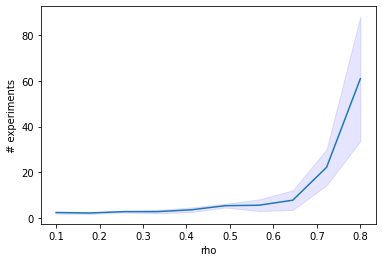

In [6]:
plot_rho_significance(rhos, ys, ci)

## Comparisons

In [26]:
def calculate_compare_mmn_data(rho, lamda, nruns):

    data1 = generate_data(rho, lamda, 1, nruns)
    data2 = generate_data(rho, lamda, 2, nruns)
    data4 = generate_data(rho, lamda, 4, nruns)

    return data1, data2, data4

def plot_compare_mnn(data, labels):

    plt.boxplot(data, labels=labels)
    plt.ylabel("Average waiting time")
    plt.show()


In [ ]:
MAX_SIM_TIME = 10000
data = calculate_compare_mmn_data(0.7, 1, 20)

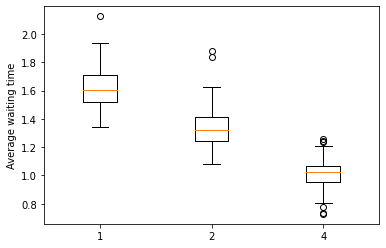

2.3160351669164707e-33, 3.4072397225415803e-88, 7.340063149575064e-45

In [29]:
plot_compare_mnn(data, ["1", "2", "4"])
print(f"{calc_pvalue(data[0], data[1])}, {calc_pvalue(data[0], data[2])}, {calc_pvalue(data[1], data[2])}", end="")

